In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

In [3]:
print((x_train.shape, y_train.shape), (x_test.shape, y_test.shape))

((60000, 28, 28), (60000,)) ((10000, 28, 28), (10000,))


In [4]:
print(np.max(x_train[0]), np.min(x_train[0]))

255 0


In [5]:
# copy pasted from keras blog on vae:

original_dim = 28*28
intermediate_dim = 64
latent_dim = 8

inputs = keras.Input(shape=(original_dim, ))
h = layers.Dense(intermediate_dim, activation='elu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='elu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=Adam(lr=3e-4))

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(np.max(x_train[0]), np.min(x_train[0]))
print(np.max(x_test[0]), np.min(x_test[0]))

1.0 0.0
1.0 0.0


In [7]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_test, x_test))

Epoch 1/30
938/938 [==============================] - 4s 4ms/step - loss: 284.4667 - val_loss: 162.2935
Epoch 2/30
938/938 [==============================] - 3s 3ms/step - loss: 154.7668 - val_loss: 139.5061
Epoch 3/30
938/938 [==============================] - 3s 3ms/step - loss: 138.8308 - val_loss: 132.5625
Epoch 4/30
938/938 [==============================] - 3s 3ms/step - loss: 132.5064 - val_loss: 127.8345
Epoch 5/30
938/938 [==============================] - 3s 3ms/step - loss: 128.1873 - val_loss: 124.4163
Epoch 6/30
938/938 [==============================] - 3s 3ms/step - loss: 124.8609 - val_loss: 121.9618
Epoch 7/30
938/938 [==============================] - 3s 3ms/step - loss: 122.7622 - val_loss: 120.2170
Epoch 8/30
938/938 [==============================] - 3s 3ms/step - loss: 120.7707 - val_loss: 118.5202
Epoch 9/30
938/938 [==============================] - 3s 3ms/step - loss: 119.3699 - val_loss: 117.4659
Epoch 10/30
938/938 [==============================] - 3s 3ms/st

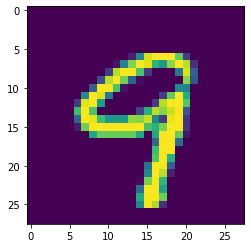

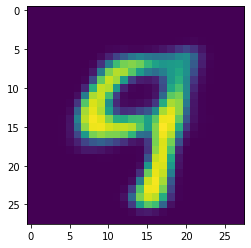

In [9]:
import matplotlib.pyplot as plt
random_index = np.random.choice(len(x_test))
sample = x_test[random_index]
sample = tf.convert_to_tensor([sample])
plt.imshow(sample.numpy().reshape(28,28))
plt.show()
plt.imshow(vae.predict(sample).reshape(28,28))
plt.show()

In [10]:
test = encoder.predict(sample)[-1][0]
print(test)

[ 0.6107109  -0.5470717   0.03850114 -1.2007537   0.24098516 -0.03376316
  0.9980599   0.13473263]


In [11]:
inp = layers.Input((latent_dim,))
x = layers.Dense(128, activation='elu')(inp)
x = layers.Dense(256, activation='elu')(x)
x = layers.Dense(64, activation='elu')(x)
out = layers.Dense(10, activation='softmax')(x)

m = keras.models.Model(inp, out)
m.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

In [12]:
x_train_ = encoder.predict(x_train)
x_test_ = encoder.predict(x_test)
x_train_ = x_train_[2]
x_test_ = x_test_[2]
x_train_ = tf.convert_to_tensor(x_train_, dtype=tf.float32)
x_test_ = tf.convert_to_tensor(x_test_, dtype=tf.float32)

In [13]:
y_train_ = []
for i in range(len(y_train)):
    a = np.zeros(10)
    a[y_train[i]] = 1
    y_train_.append(a)
y_test_ = []
for i in range(len(y_test)):
    a = np.zeros(10)
    a[y_test[i]] = 1
    y_test_.append(a)

In [14]:
y_train_ = tf.convert_to_tensor(y_train_, dtype=tf.float32)
y_test_ = tf.convert_to_tensor(y_test_, dtype=tf.float32)

In [15]:
m.fit(x_train_, y_train_, epochs=10, validation_data=(x_test_, y_test_), batch_size=64)

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.5996 - accuracy: 0.8115 - val_loss: 0.3042 - val_accuracy: 0.9035
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3039 - accuracy: 0.9005 - val_loss: 0.2810 - val_accuracy: 0.9106
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2759 - accuracy: 0.9094 - val_loss: 0.2753 - val_accuracy: 0.9112
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2561 - accuracy: 0.9148 - val_loss: 0.2553 - val_accuracy: 0.9170
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2488 - accuracy: 0.9173 - val_loss: 0.2542 - val_accuracy: 0.9150
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2424 - accuracy: 0.9208 - val_loss: 0.2519 - val_accuracy: 0.9170
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2368 - accuracy: 0.9205 - val_loss: 0.2416 - val_accuracy: 0.9218
Epoch 

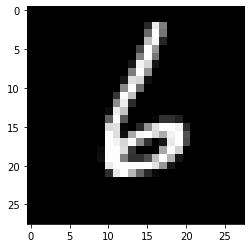

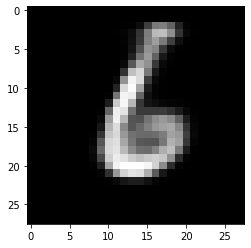

In [16]:
random_index = np.random.choice(len(x_test))
sample = x_test[random_index]
sample = tf.convert_to_tensor([sample])
plt.imshow(sample.numpy().reshape(28,28), 'gray')
plt.show()
plt.imshow(vae.predict(sample).reshape(28,28), 'gray')
plt.show()

In [17]:
test = encoder.predict(sample)[-1][0]

In [18]:
pred = m.predict(tf.convert_to_tensor([test], dtype=tf.float32))[0]
print(pred)
print(np.argmax(pred))

[6.6983312e-06 1.1035427e-05 1.4824808e-06 8.4419080e-06 1.4386990e-04
 1.0729709e-05 9.9981624e-01 1.0292011e-08 1.6027834e-06 8.7159224e-10]
6


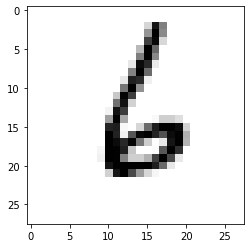

[8.29981491e-06 1.03066841e-05 2.19082085e-06 1.37736497e-05
 1.40367745e-04 2.28624085e-05 9.99800265e-01 1.18256835e-08
 2.07045287e-06 9.37266931e-10]
6


In [19]:
# predictions with converted samples are consistent
inverted_sample = []
for i in range(len(sample)):
    for j in range(len(sample[i])):
        inverted_sample.append(0 + (1-sample[i][j]))
inverted_sample = np.array(inverted_sample)
plt.imshow(inverted_sample.reshape(28,28), 'gray')
plt.show()
test = encoder.predict(sample)[-1][0]
pred = m.predict(tf.convert_to_tensor([test], dtype=tf.float32))[0]
print(pred)
print(np.argmax(pred))